In [1]:
!git clone https://github.com/Bestlismz/Flower.git

Cloning into 'Flower'...
remote: Enumerating objects: 13758, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 13758 (delta 0), reused 3 (delta 0), pack-reused 13755
Receiving objects: 100% (13758/13758), 245.92 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (13750/13750), done.


In [2]:
%cd Flower


/content/Flower


In [3]:
!ls

 classname.txt	   main2.ipynb	'README copy.md'   train       val
 Flower_model.h5   main3.ipynb	 README.md	   train.csv   val.csv


In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2

base_val_dir = 'val/'
base_train_dir = 'train/'
img_size = 180
batch = 32


train_ds = tf.keras.utils.image_dataset_from_directory(
    base_train_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch,
    image_size=(img_size, img_size))

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_val_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch,
    image_size=(img_size, img_size))

flower_names = train_ds.class_names
print(flower_names)

Found 13642 files belonging to 14 classes.
Using 10914 files for training.
Found 98 files belonging to 14 classes.
Using 19 files for validation.
['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip', 'water_lily']


In [25]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(flower_names), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


Epoch 1/15
342/342 [==============================] - 18s 42ms/step - loss: 3.4408 - accuracy: 0.6572 - val_loss: 1.3161 - val_accuracy: 0.8947
Epoch 2/15
342/342 [==============================] - 13s 39ms/step - loss: 1.4641 - accuracy: 0.7275 - val_loss: 0.9530 - val_accuracy: 0.8421
Epoch 3/15
342/342 [==============================] - 14s 40ms/step - loss: 1.2653 - accuracy: 0.7301 - val_loss: 0.8063 - val_accuracy: 0.8421
Epoch 4/15
342/342 [==============================] - 14s 40ms/step - loss: 1.2180 - accuracy: 0.7360 - val_loss: 0.8627 - val_accuracy: 0.8947
Epoch 5/15
342/342 [==============================] - 14s 39ms/step - loss: 1.2186 - accuracy: 0.7376 - val_loss: 0.8797 - val_accuracy: 0.8421
Epoch 6/15
342/342 [==============================] - 13s 38ms/step - loss: 1.1961 - accuracy: 0.7379 - val_loss: 0.7476 - val_accuracy: 0.8947
Epoch 7/15
342/342 [==============================] - 13s 38ms/step - loss: 1.1975 - accuracy: 0.7317 - val_loss: 0.8241 - val_accuracy:

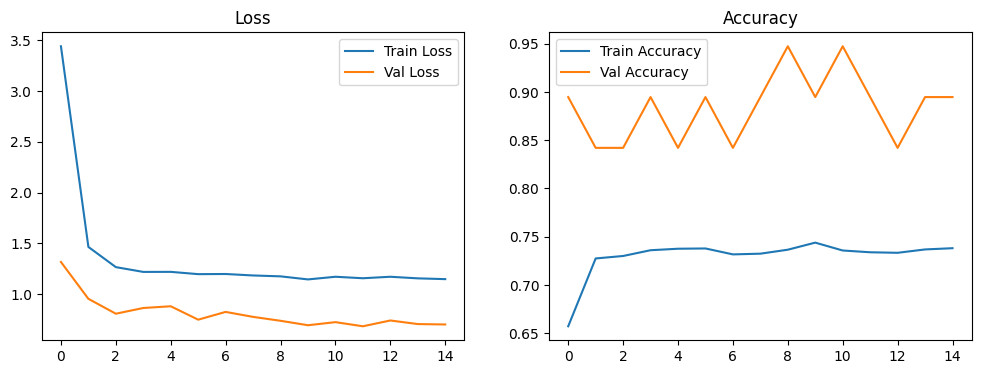

In [26]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)
model.save('Flower_model_augmented.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [29]:
loaded_model = tf.keras.models.load_model('Flower_model_augmented.h5')
test_loss, test_accuracy = loaded_model.evaluate(val_ds)
print(f"Accuracy: {test_accuracy*100:.2f}%")

def classify_images(image_path, model, img_size, flower_names):
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = np.expand_dims(input_image_array, axis=0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)]
    return outcome

result = classify_images('val/california_poppy/42796824532_89ccc7ddd0_c.jpg', loaded_model, img_size, flower_names)
print(result)


1/1 [==============================] - 1s 1s/step - loss: 0.7004 - accuracy: 0.8947
Accuracy: 89.47%
1/1 [==============================] - 1s 1s/step
The Image belongs to coreopsis
